# Model Reduction on a Linear SDE

In [1]:
include("modgen_LSDE.jl")
include("..\\..\\Tools\\Model_Reduction_Dev.jl")

vector_wiener_filter_fft

In [2]:
using JLD
using PyPlot
using DSP: nextfastfft

## Generate the data 

In [3]:
A = -[0.5 0; 0 0.9]
σ = [1 0; 0 1]
Xo = [1; 1]
t_disc = 1000
gap = 1
scheme = "EM"

t_start = 0
t_stop = 1e5
h = 0.01

Δt      = h*gap
M_out   = 20

X = modgen_LSDE(t_start,t_stop,h,
    A = A,
    σ = σ,
    Xo = Xo,
    t_disc = t_disc,
    gap = gap)

2×9900001 Array{Float64,2}:
  0.854285   0.881901   0.851973  …   0.521391   0.447404   0.490085
 -0.639107  -0.812605  -0.823067     -0.502736  -0.60214   -0.675044

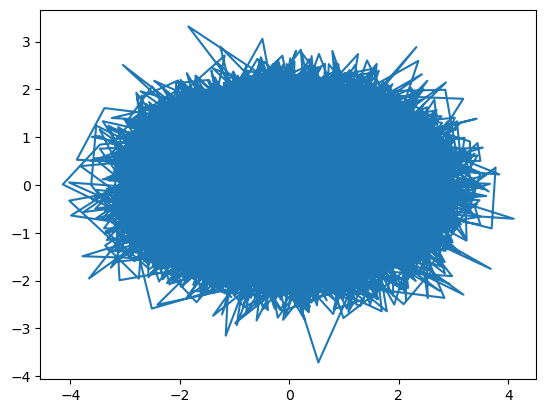

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000000EF3F08>

In [5]:
plot(X[1,1:100:end],X[2,1:100:end])

In [6]:
d, N = size(X)

nfft = nextfastfft(N)
X = [X zeros(d,nfft-N)]

τ_exp, τ_int    = auto_times(X[1,:])*Δt
N_eff           = N*Δt/τ_int

48391.12075886851

In [10]:
Psi(x) = x
n = 2
p = 150
ty = "bin"
par = 2000

@time h_wf = get_wf(X,Psi;n,p,ty,par,M_out = 20)

2000

In [62]:
h_ana = zeros(2,2,1)
h_ana[:,:,1] =I + h*A

2×2 Array{Float64,2}:
  0.995  -0.0
 -0.0     0.991

### Dive into `get_wf`

Here we dive into the `get_wf` function and take a look at how it is approximating a few thinbgs. 

In [8]:
signal = X # Vector valued process
Psi # column vector valued function

M_out = 20
rl = true
Preds = false
PI = false
rtol = 1e-6

# We would like a presample since we want the
# times series to be offset by one.

sig = signal[:,2:end] # sig is now one a head of signal
d, steps = size(sig)
nu = size(Psi(zeros(d,1)),1)

pred = complex(zeros(nu, steps))
for n = 1:steps
    pred[:,n] = Psi(signal[:,n])
end # pred is now even with signal and therefore one step
    # step behind sig. I.e. pred[:,n] = Psi(sig[:,n-1])
    # which is what we want so as to ensure the reduced
    # model can run explicitly.

#### Dive into `vector_wiener_filter_fft(sig, pred; M_out,n, p, par, ty, PI, rtol)`

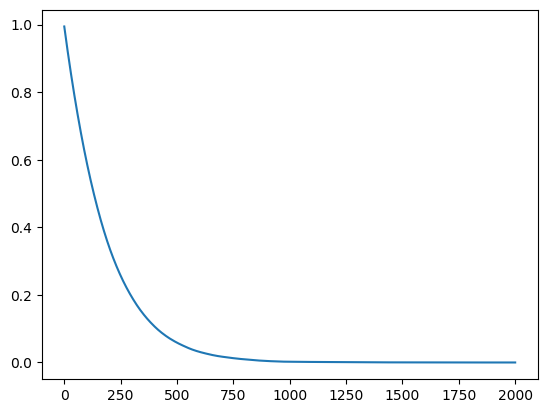

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000012B0308>

In [11]:
win = "Par"

d, stepsy = size(sig)
nu, stepsx = size(pred)

stepsx == stepsy || print("X and Y are not the same length. Taking min.")
steps = minimum([stepsx stepsy])
nfft = nextfastfft(steps)
nffth = Int(floor(nfft/2))
L = par

R_pred_smoothed = matrix_autocov_seq(pred,
   L = L,
   steps = steps,
   nu = nu,
   win = win
   )

plot(real(R_pred_smoothed[1,1,:]))

In [12]:
# Compute coefficients of spectral factorization of z-spect-pred
l = PI ? spectfact_matrix_CKMS_pinv(R_pred_smoothed,rtol = rtol) :
         spectfact_matrix_CKMS(R_pred_smoothed)

l_pad_minus = nfft >= L+1 ? cat(dims = 3,l,zeros(nu,nu,nfft - L - 1)) :
                           l[:,:,1:nfft]

z_spect_pred_minus_num_fft = fft(l_pad_minus,3)
z_spect_pred_plus_num_fft = complex(zeros(nu,nu,nfft))
for i = 1 : nfft
    z_spect_pred_plus_num_fft[:,:,i] = z_spect_pred_minus_num_fft[:,:,i]'
end

Number of CKMS iterations: 1334
errK errR : 8.080688192423643e-11 2.8341174672275757e-13


In [13]:
#recovered spectral density of pred
z_spect_pred_recoverd = complex(zeros(nu,nu,nfft))
for i = 1 : nfft
    z_spect_pred_recoverd[:,:,i] =z_spect_pred_minus_num_fft[:,:,i]*
                                  z_spect_pred_plus_num_fft[:,:,i]
end

z_spect_pred = z_crossspect_fft(pred, pred; nfft, n, p, ty);

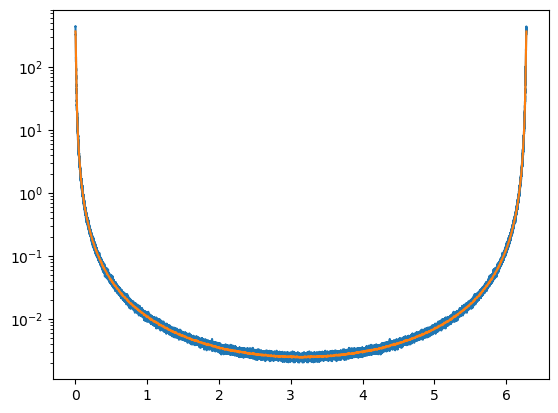

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000001F3DB9F08>
 PyObject <matplotlib.lines.Line2D object at 0x00000001F3DBF388>

In [14]:
semilogy(2π*(1:nfft)/nfft,[real(z_spect_pred[1,1,
                :]) real(z_spect_pred_recoverd[1,1,
                :])]) # z_spect_pred[1,2,
                #:] z_spect_pred[2,2,:]]))
# axis([0,2000,-20,300])

In [15]:
# Compute z-cross-spectrum of sigpred
z_crossspect_sigpred_num_fft = z_crossspect_fft(sig, pred;
                    nfft, n, p, ty);

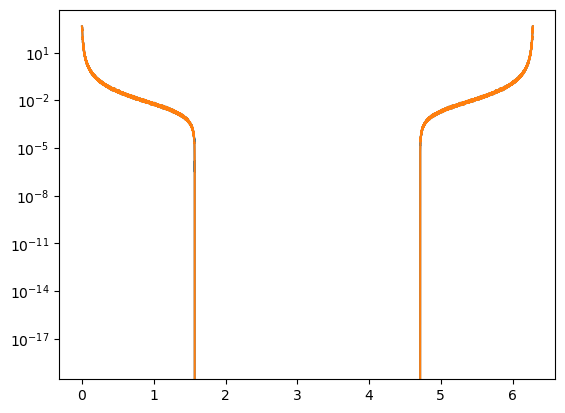

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000028E4CAA08>
 PyObject <matplotlib.lines.Line2D object at 0x000000028E4AB048>

In [19]:
Theta = 2π*(1:nfft)/nfft

uz_spect_pred = zeros(2,2,nfft)
for i in 1:nfft
    uz_spect_pred[:,:,i] = real(exp(-Theta[i]*im).*z_spect_pred[:,:,i])
end

semilogy(2π*(1:nfft)/nfft,[real(z_crossspect_sigpred_num_fft[1,1,:]) uz_spect_pred[1,1,:]])

## Get reduced (reproduced) model (no noise) 

### One-step prediction error

In [32]:
# h_wf = h_ana

d, N  = size(X)
nu    = size(Psi(X[:,1]),1) 
M_out = size(h_wf,3)

X_rm = zeros(d,N); X_rm[:,1:M_out] = X[:,1:M_out]

PSI = zeros(nu,N); 
for i = 1:M_out
    PSI[:,i] = Psi(X_rm[:,i])
end

for i = M_out + 1 : N
    X_rm[:,i] = sum(h_wf[:,:,k]*PSI[:,i-k] for k = 1:M_out, dims = 2)
    PSI[:,i] = Psi(X_rm[:,i])
end



In [20]:
d, N  = size(X)
nu    = size(Psi(X[:,1]),1) 
M_out = size(h_wf,3)

X_rm_n = zeros(d,N); X_rm_n[:,1:M_out] = X[:,1:M_out]

PSI_n = zeros(nu,N); 
for i = 1:M_out
    PSI_n[:,i] = Psi(X_rm_n[:,i])
end

for i = M_out + 1 : N
    X_rm_n[:,i] = sum(h_wf[:,:,k]*PSI_n[:,i-k] for k = 1:M_out, dims = 2) + sqrt(h)*σ*randn(nu,1)
    PSI_n[:,i] = Psi(X_rm_n[:,i])
end

In [21]:
X_rm_n
mean(X_rm_n,dims = 2)
var(X_rm_n,dims = 2)

2×1 Array{Float64,2}:
 0.5824222478615599
 0.46690285644716223

In [22]:
mean(X,dims = 2)
var(X,dims = 2)

2×1 Array{Float64,2}:
 0.9944976547412244
 0.5583417883482378

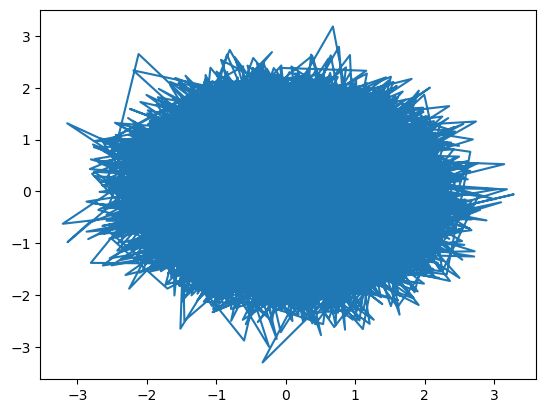

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000002353E0A88>

In [24]:
plot(X_rm_n[1,1:100:end],X_rm_n[2,1:100:end])

In [66]:
data = Dict(
        "h_wf" => h_wf,
        "A" => A,
        "σ" => σ,
        "p" => p,
        "n" => n,
        "ty" => ty,
        "Xo" => Xo,
        "t_disc" => t_disc,
        "gap" => gap,
        "t_start" => t_start,
        "t_stop" => t_start,
        "h" => h,
        "X" => X,
        "X__rm" => X_rm,
        "X__rm_n" => X_rm_n)

save("Data\\LSDE_wfs.jld",data)

In [67]:
data = load("Data\\LSDE_wfs.jld")

Dict{String,Any} with 20 entries:
  "p"                     => 150
  "ty"                    => "bin"
  "h"                     => 0.01
  "_creator\\JULIA_PATCH" => 0x00000001
  "t_disc"                => 1000
  "σ"                     => [1 0; 0 1]
  "t_start"               => 0
  "t_stop"                => 0
  "Xo"                    => [1, 1]
  "A"                     => [-0.5 -0.0; -0.0 -0.9]
  "X"                     => [-1.30342 -1.21778 … 0.611235 0.619431; 0.393234 0…
  "X__rm_n"               => [-1.30342 -1.21778 … -0.106663 -0.123154; 0.393234…
  "_creator\\JULIA_MINOR" => 0x00000005
  "_creator\\ENDIAN_BOM"  => 0x04030201
  "h_wf"                  => [0.994042 0.000399091; -0.000809157 0.990106]…
  "gap"                   => 1
  "_creator\\WORD_SIZE"   => 64
  "X__rm"                 => [-0.951561 -0.946803 … -4.9e-322 -4.9e-322; -1.849…
  "_creator\\JULIA_MAJOR" => 0x00000001
  "n"                     => 2

## Autocorrelations

In [25]:
A = matrix_autocov_seq(X;L = 1500,win = "par")
A_rm_n = matrix_autocov_seq(X_rm_n;L = 1500,win = "par");

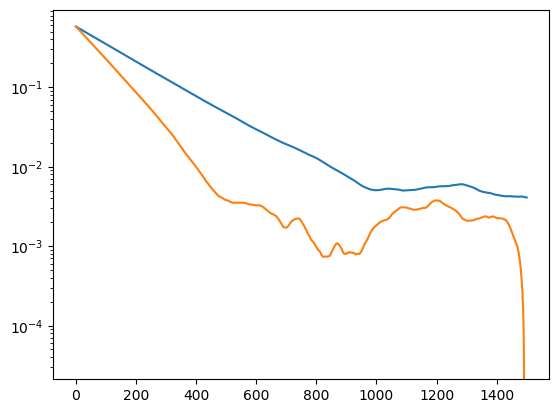

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000026CAE48>
 PyObject <matplotlib.lines.Line2D object at 0x00000000026CE2C8>

In [30]:
semilogy(real([A[1,1,:].*A_rm_n[1,1,1]/A[1,1,1] A_rm_n[1,1,:]]))